# Problem set 2

## Team
Please write here your names and team number.

* Team name: Group A
* Team members: Aditya Narayan Rai, Monserrat Lopez Perez & Ray Hossain

## Using Colab with GitHub
To utilize GPU support for model training, we highly recommend to open this notebook with Google Colab. Simply, change the domain from 'github.com' to 'githubtocolab.com' and refresh the site to open the notebook in Colab.
If you haven't used Colab before with private repositories, make sure to grant Colab access to your private repositories (see screenshot) and after that just try to change the domain again.

Finally, you should make sure that you add a GPU to your Colab notebook. You can do so by clicking on `Runtime` →  `Change runtime type` → `Hardware accelerator`  →  `GPU`.

## Submission

Make sure that you always commit and push the changes you make in Colab back to GitHub. To do so from within a Colab notebook, click `File` → `Save a copy in GitHub`. You will be prompted to add a commit message, and after you click OK, the notebook will be pushed to your repository. Only changes that are visible in your GitHub repository on the main branch will be considered for grading. If you close Colab in your browser without pushing your changes to GitHub or saving them on Google Drive, they will be lost.

Make sure that all your work has been pushed to GitHub before the deadline.


Check that the GPU  enabled in your colab notebook by running the cell below.

In [4]:
import torch
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: Tesla T4


You will be working with the LFW (Labeled Faces in the Wild) dataset. The dataset contains 13233 pictures of 5749 people. Running the lines below will download the data and return a random picture from the dataset.

Files already downloaded and verified
The dataset has 13233 images


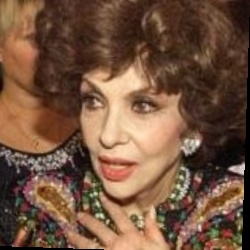

In [5]:
from torchvision.datasets import LFWPeople
import os
import numpy as np

download = LFWPeople(root=os.getcwd(), download=True) #downloads the dataset to your current directory
label_file = os.path.join(download.root, download.names)
print(f"The dataset has {len(download)} images")
pic, _ = download[np.random.randint(len(download))]
pic

# Task 1: Transform the data

 Your task is to train a classifier to classify the celebrities in the dataset. We want to select only the 50 most frequent people in the dataset, all the other people should be mapped to a common class.
- Implement the function `most_frequent_n_people` that reads names and frequencies from the `lfw-names.txt` and returns dictionaries mapping names to labels and frequencies of the most frequent people.
- Plot a histogram with the frequencies of the most frequent people sorted by their new labels (`[0-49]`). Make sure to insert both name and label in the histogram (e.g. `Arnold Schwarzenegger:4`).
- Implement the function `retrieve_datasets` that takes as input the mapping of old to new labels and returns train and test datasets which contain the input tensors and corresponding new labels. All other less frequent people should be mapped to the label `n_classes`. The train and test dataset should have a size proportion of 80-20.

In [6]:
# Implement the function most_frequent_n_people that reads names and frequencies from the lfw-names.txt and returns dictionaries mapping names to labels and frequencies of the most frequent people.

from torch.utils.data import DataLoader, Subset, Dataset, random_split
import matplotlib.pyplot as plt

def most_frequent_n_people(label_file, n_classes):
    with open(label_file, 'r') as f:
        lines = f.readlines()

    name_to_old_label = {} # Maps names to their original indices.
    name_to_new_label = {} # Will map the most frequent names to new labels.
    name_to_count = {} # Stores the frequency count of each name.

    for i, line in enumerate(lines[1:]):  # Skip the header line
        name, count = line.strip().split('\t')
        name_to_old_label[name] = i
        name_to_count[name] = int(count)

    # Sort names by frequency in descending order
    sorted_names = sorted(name_to_count, key=name_to_count.get, reverse=True)

    # Assign new labels to the most frequent people
    for i, name in enumerate(sorted_names[:n_classes]):
        name_to_new_label[name] = i

    return name_to_old_label, name_to_new_label, name_to_count

In [7]:
# Funtion to plot a histogram with the frequencies of the most frequent people sorted by their new labels ([0-49]).
def plot_histogram(name_to_new_label, name_to_count):
    names = list(name_to_new_label.keys())
    frequencies = [name_to_count[name] for name in names]
    labels = [name_to_new_label[name] for name in names]

    fig, ax = plt.subplots()
    ax.bar(labels, frequencies)

    ax.set_xlabel("Label")
    ax.set_ylabel("Frequency")
    ax.set_title("Frequencies of Most Frequent People")

    for i, (name, label, frequency) in enumerate(zip(names, labels, frequencies)):
        ax.text(label, frequency, f"{name}:{label}", ha='center', va='bottom', rotation=90)

    return fig, ax

Text(0.5, 0.98, 'Most frequent 50 people and new labels')

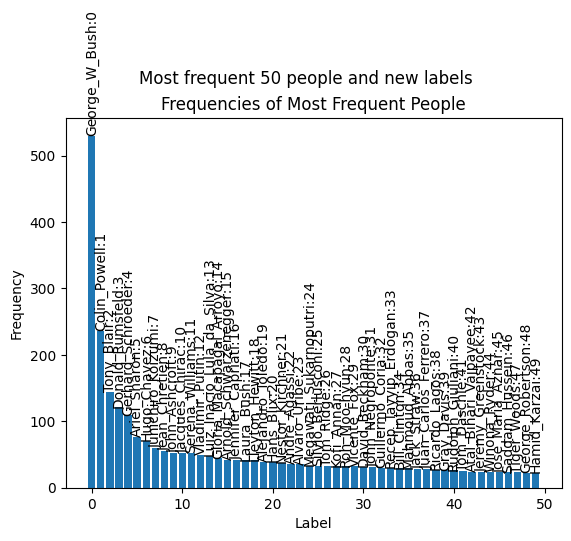

In [8]:
# Histogram
n_classes =50
name_to_old_label, name_to_new_label, name_to_count = most_frequent_n_people(label_file, n_classes)
fig, ax = plot_histogram(name_to_new_label, name_to_count)
fig.suptitle(f'Most frequent {n_classes} people and new labels')

<BarContainer object of 2 artists>

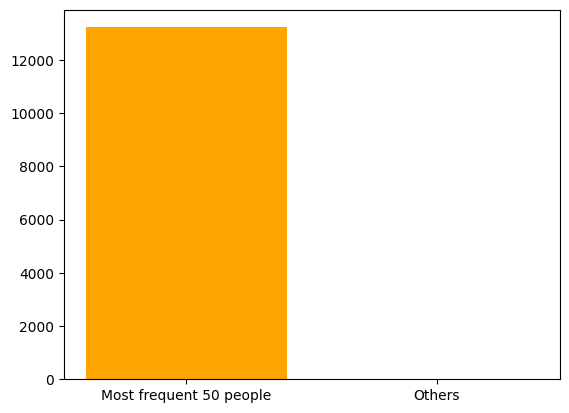

In [9]:
# This graph is not working because name_to_count.values() alculates the sum of all the values in name_to_count, which stores the frequency of each person in the dataset
tot_people = sum(name_to_count.values())
tot_others = len(download) - tot_people
plt.bar([0,1], [tot_people, tot_others], tick_label=[f'Most frequent {n_classes} people', 'Others'], color='orange')

Text(0.5, 1.0, '50 Most Frequent People vs Others')

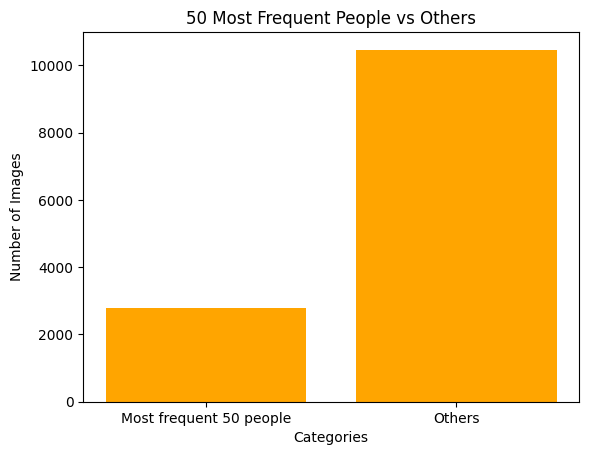

In [10]:
# This only counts for the total number of images belonging to the most frequent 50 people
tot_people = sum(name_to_count[name] for name in name_to_new_label)
tot_others = len(download) - tot_people
plt.bar([0,1], [tot_people, tot_others], tick_label=[f'Most frequent {n_classes} people', 'Others'], color='orange')
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('50 Most Frequent People vs Others')

In [11]:
#  Implement the function retrieve_datasets that takes as input the mapping of old to new labels and returns train and test datasets which contain the input tensors and corresponding new labels.
#  All other less frequent people should be mapped to the label n_classes.
from torch.utils.data import DataLoader, Subset, Dataset, random_split
import numpy as np
import torch

def retrieve_datasets(old_to_new_label, n_classes, proportion=(0.8, 0.2)):

    class CustomDataset(Dataset):
        def __init__(self, download, old_to_new_label, n_classes):
            self.download = download
            self.old_to_new_label = old_to_new_label
            self.n_classes = n_classes

        def __len__(self):
            return len(self.download)

        def __getitem__(self, idx):
            image, old_label = self.download[idx]
            new_label = self.old_to_new_label.get(old_label, self.n_classes)  # Map to n_classes if not in most frequent
            image_tensor = np.array(image)  # Convert PIL image to NumPy array
            image_tensor = image_tensor.transpose(2, 0, 1)  # Change to CHW format
            image_tensor = torch.from_numpy(image_tensor).float()  # Convert to PyTorch tensor
            return image_tensor, new_label

    # Create a custom dataset
    dataset = CustomDataset(download, old_to_new_label, n_classes)

    # Split the dataset into train and test sets
    train_size = int(proportion[0] * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    return train_dataset, test_dataset

In [12]:
old_to_new_label = {old_val: name_to_new_label.get(key, n_classes) for key, old_val in name_to_old_label.items()}
train_dataset, test_dataset = retrieve_datasets(old_to_new_label, n_classes)
print(f"Len of train dataset {len(train_dataset)}, len of test dataset: {len(test_dataset)}")

Len of train dataset 10586, len of test dataset: 2647


## Task 2: Implement a CNN model
Implement a classification model to predict the label of the faces in the dataset. You are free to experiment with the network architecture. However your model **must** contain:
- Convolutional, linear, and pooling layers only.
- At least 5 convolutional layers, with at least two different kernel sizes
- A final output layer that is customizable to the number of classes that we want to predict.
- If you are adding identity/skip connections, make sure to change to model parent class to `nn.Module` and to implement a `forward()` function.
- Briefly explain why you chose the particular architecture you implemented (around 2-3 sentences).


In [16]:
import torch
import torch.nn as nn

class MyCNNModel(nn.Sequential):

    def __init__(self, n_classes):
        super().__init__()

        # Convolutional layers: Used Ai for the code
        self.conv_layers = nn.Sequential(
            # Layer 1: 11x11 Conv, 96 filters, stride 4, no padding
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),   # After each convolution, a ReLU activation function is applied to introduce non-linearity to the model.
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Layer 2: 5x5 Conv, 256 filters, padding 2
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Layer 3: 3x3 Conv, 384 filters, padding 1
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(),

            # Layer 4: 3x3 Conv, 384 filters, padding 1
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(),

            # Layer 5: 3x3 Conv, 256 filters, padding 1
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),  # Adjusted based on output of conv layers
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, n_classes)
        )

    def forward(self, x):
        # Pass through convolutional layers
        x = self.conv_layers(x)
        # Flatten the tensor before passing to fully connected layers
        x = torch.flatten(x, 1)
        # Pass through fully connected layers
        x = self.fc_layers(x)
        return x

Briefly explain why you chose the particular architecture you implemented (around 2-3 sentences). *PENDING*

In [17]:
### Used Ai for this bit
'''#TODO: print one iteration of your model to test its correctness'''

my_model = MyCNNModel(n_classes+1)
X, y = train_dataset[0]
output = my_model(X[None, :])
input = X[None, :]


# Sanity checks
print(f"Input shape: {input.shape}")      # Shape of the input tensor
print(f"Output shape: {output.shape}")  # Shape of the model output (should be [1, n_classes])

Input shape: torch.Size([1, 3, 250, 250])
Output shape: torch.Size([1, 51])


## Training

We define a `Trainer` function to train our model that returns avg loss and avg accuracy per epoch. We set the configuration of the trainer is set in the `cfg` dictionary. Use the trainer to train your model and make sure to print and plot avg loss and accuracy using the in-built commands.

In [18]:
from datetime import datetime as dt
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

cfg = {
    'batch_size': 64,
    'criterion': 'CrossEntropyLoss', #change to 'nn.NLLLoss' if you are applying a softmax in the last layer of your model
    'epochs': 1,
    'learning_rate': 0.001,
    'optimizer':'Adam',
    'seed':42,

}

class Trainer:

    def __init__(self, model, cfg):
        self.model = model
        self.cfg = cfg

        for key, val in cfg.items():
            setattr(self, key, val)

        self.optimizer = getattr(optim, self.optimizer)(self.model.parameters(), lr=self.learning_rate)
        self.criterion = getattr(nn, self.criterion)()


    def iter_step(self, X, Y):
        Y_pred = self.model(X)
        loss = self.criterion(Y_pred, Y)
        acc = (Y_pred.argmax(dim=-1) == Y).to(torch.float).mean()
        return loss, acc

    def train(self, dataset):
        train_dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, generator=torch.manual_seed(self.seed))
        avg_loss, avg_acc = [], []
        tot_loss, tot_acc = 0, 0
        for epoch in range(self.epochs):
            iterdata = iter(train_dataloader)
            train_size = len(iterdata)
            pbar = tqdm(iterable=range(train_size))

            for i in pbar:
                batch = next(iterdata)
                X_batch, Y_batch = batch #this is needed for compatibility with pbar
                self.model.train()
                self.optimizer.zero_grad()
                loss, acc = self.iter_step(X_batch, Y_batch)
                loss.backward()
                self.optimizer.step()
                tot_loss += loss.item()
                tot_acc += acc.item()
                avg_loss.append(tot_loss / max(1, len(avg_loss)))
                avg_acc.append(tot_acc / max(1, len(avg_acc)))
                desc = f'Epoch:{epoch} - Avg loss:{avg_loss[-1]:.5f} - Avg acc:{avg_acc[-1]:.5f}'
                pbar.set_description(desc)

        return avg_loss, avg_acc

    def test(self, dataset):
        avg_test_loss, avg_test_acc = [], []
        test_loss, test_acc = 0, 0
        self.model.eval()
        test_dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, generator=torch.manual_seed(self.seed))

        for X_batch, Y_batch in iter(test_dataloader):
            loss, acc = self.iter_step(X_batch, Y_batch)
            test_loss += loss.item()
            test_acc += acc
            avg_test_loss.append(test_loss / max(1, len(avg_test_loss)))
            avg_test_acc.append(test_acc / max(1, len(avg_test_acc)))

        return avg_test_loss, avg_test_acc

In [19]:
'''#TODO: train your model, plot accuracy and loss by iteration (one iteration=one batch)'''
my_trainer = Trainer(my_model, cfg)
train_loss, train_acc = my_trainer.train(train_dataset)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(train_loss)), train_loss)
ax1.plot(range(len(train_acc)), train_acc)
ax0.set_title('Training loss')
ax1.set_title('Training accuracy')

  0%|          | 0/166 [00:06<?, ?it/s]


KeyboardInterrupt: 

Text(0.5, 1.0, 'Test accuracy')

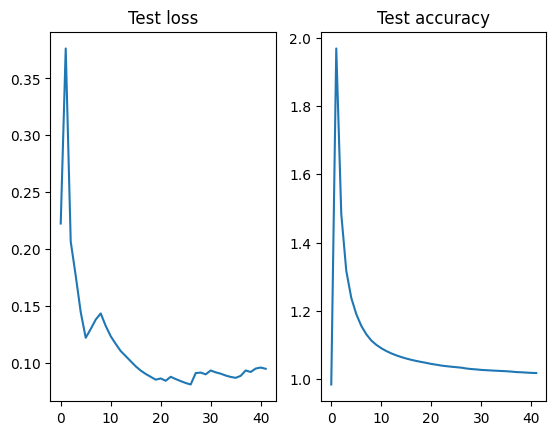

In [14]:
'''#TODO: test your model, plot accuracy and loss by iteration (one iteration=one batch)'''
test_loss, test_acc = my_trainer.test(test_dataset)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(test_loss)), test_loss)
ax1.plot(range(len(test_acc)), test_acc)
ax0.set_title('Test loss')
ax1.set_title('Test accuracy')

## Task 3: Tune your model hyperparameters (optional)

Implement a method <code>grid_search</code>, which looks for the best possible learning rates and training batch sizes for your model <code>MyCNNModel</code> and returns the best possible model, the corresponding training configuration, and the final training avg losses and accuracies (as numbers).

In [15]:
def grid_search(train_dataset, cfg, learning_rates=[10**-1, 10**-2, 10**-3], batch_sizes=[2**5, 2**6, 2**7]):
    '''#TODO: here your code '''
    return best_model, best_cfg, best_avg_loss, best_avg_acc


best_model, best_cfg, best_avg_loss, best_avg_acc = grid_search(train_dataset, cfg, learning_rates=[10**-1, 10**-2, 10**-3], batch_sizes=[2**5, 2**6, 2**7])
print(f"Best model achieves {best_avg_loss:.2f} loss and {best_avg_acc:.1%} accuracy").


SyntaxError: invalid syntax (<ipython-input-15-353966b6a1f9>, line 7)

## Task 3: Load and fine-tune a pre-trained model

<ul>
  <li>Load and train a pre-trained model for classification problems, such as those made available in <a href="https://huggingface.co/docs/timm">Hugging Face's timm library</a>. </li>
  <li> Make sure to modify the output layer to be compatible with the number of classes. </li>
  <li>Print a summary of your results.</li>
  <li>Briefly explain why you chose the particular architecture you did (around 2-3 sentences).</li>
  </ul>
  
<b>Note</b>: in case you run into computing-related (e.g. memory) issues, consider choosing another model.

In [13]:
# pip install timm

In [14]:
import timm
import torch.nn as nn

In [23]:
'''#TODO: import and fine-tune a pretrained model'''
# Load the pre-trained model ResNet18
loaded_model = timm.create_model("resnet18", pretrained=True)

# Modify the output layer to be compatible with the number of classes.
num_classes = n_classes + 1
in_features = loaded_model.fc.in_features
loaded_model.fc = nn.Linear(in_features, num_classes)

# Instantiate the trainer
loaded_trainer = Trainer(loaded_model, cfg)

In [ ]:
'''#TODO: train your model, plot accuracy and loss by iteration (one iteration=one batch)'''
# Train the loaded model
train_loss, train_acc = loaded_trainer.train(train_dataset)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(train_loss)), train_loss)
ax1.plot(range(len(train_acc)), train_acc)
ax0.set_title('Training loss')
ax1.set_title('Training accuracy')

Epoch:0 - Avg loss:1.56496 - Avg acc:1.02214:   8%|▊         | 13/166 [02:58<34:10, 13.40s/it]

In [ ]:
'''#TODO: test your model, plot accuracy and loss by iteration (one iteration=one batch)'''
# Test the loaded model
test_loss, test_acc = loaded_trainer.test(test_dataset)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(test_loss)), test_loss)
ax1.plot(range(len(test_acc)), test_acc)
ax0.set_title('Test loss')
ax1.set_title('Test accuracy')


ResNet-18 is a convolutional neural network that is 18 layers deep. This model was chosen for its balance of performance and computational efficiency. It's a widely used architecture known for its ability to  learn effective features and generalize well to various image classification tasks.

<a name="results-and-discussion"></a>
# Task  4: Results and discussion

Report the final metrics and make a few comments on the overall performance for the networks you implemented (3-4 lines).

| Test metric         | your model | pre-trained model | your tuned model (optional) |
|---------------------|--------------------|-------------------|-----------------------|
| Accuracy (train)           |              |             |                |                     
| Loss (train)               |               |             |                |    
| Accuracy (test)           |              |             |                |                     
| Loss (test)               |               |             |                |              
             



